In [1]:
# !git clone https://github.com/nikheelpandey/contastive_learning.git
# import os
# os.chdir('./contastive_learning/')

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.transforms as T
import torchvision
import torch 
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import numpy as np
from tensorboardX import SummaryWriter
from tqdm import tqdm_notebook as tqdm 
import os
import time
from datetime import datetime 
from knn_monitor import knn_monitor
from model import ContrastiveLearner
from logger import Logger
import torch.nn as nn
import torch.nn.functional as F
from PIL import ImageFilter
from PIL import Image
from dataset_loader import get_train_mem_test_dataloaders, gpu_train_transformer,gpu_test_transformer
import kornia
%matplotlib inline

In [3]:
class ContrastiveLoss(nn.Module):

    def __init__(self, temp=0.5, normalize= False):
        super().__init__()
        self.temp = temp
        self.normalize = normalize

    def forward(self,xi,xj):

        z1 = F.normalize(xi, dim=1)
        z2 = F.normalize(xj, dim=1)
        
        N, Z = z1.shape 
        device = z1.device 
        
        representations = torch.cat([z1, z2], dim=0)
        similarity_matrix = torch.mm(representations, representations.T) 

        # create positive matches
        l_pos = torch.diag(similarity_matrix, N)
        r_pos = torch.diag(similarity_matrix, -N)
        positives = torch.cat([l_pos, r_pos]).view(2 * N, 1)
        
        diag = torch.eye(2*N, dtype=torch.bool,device=device)
        diag[N:,:N] = diag[:N,N:] = diag[:N,:N]        
        negatives = similarity_matrix[~diag].view(2*N, -1)    
        
        logits = torch.cat([positives, negatives], dim=1)
        logits /= self.temp
        labels = torch.zeros(2*N, device=device, dtype=torch.int64)
        loss = F.cross_entropy(logits, labels, reduction='sum')
        
        return loss / (2 * N)

In [4]:
main = torch.rand(4,256)
augm = torch.rand(4,256) 
loss = ContrastiveLoss()
loss(main,augm)

tensor(1.9632)

In [5]:
from torchvision.models import resnet18


def get_backbone(backbone, castrate=True):
    if castrate:
        backbone.output_dim = backbone.fc.in_features
        backbone.fc = torch.nn.Identity()
    return backbone

class ProjectionHead(nn.Module):
    def __init__(self,in_shape,out_shape=256):
        super().__init__()
        hidden_shape = in_shape//2

        self.layer_1 = nn.Sequential(
            nn.Linear(in_shape,hidden_shape),
            nn.ReLU(inplace=True)
        )

        self.layer_2 = nn.Linear(hidden_shape,out_shape)

    def forward(self,x):
        x = self.layer_1(x)
        x = self.layer_2(x)

        return x


class ContrastiveLearner(nn.Module):
    def __init__(self, backbone=resnet18(pretrained=False), 
                 projection_head=None):
        super().__init__()

        self.backbone = get_backbone(backbone)
        self.projection_head = ProjectionHead(backbone.output_dim)
        self.loss = ContrastiveLoss(temp=0.5, normalize= True)

        self.encoder = nn.Sequential(
            self.backbone,
            self.projection_head
        )

    def forward(self,x,x_):
        
        z   = self.encoder(x)
        z_  = self.encoder(x_)
        loss= self.loss(z,z_)

        return loss

In [6]:
uid = 'SimCLR'
dataset_name = 'cifar10'
data_dir = 'dataset'
ckpt_dir = "./ckpt"
features = 128
batch_size = batch = 512
epochs = 1
lr = 1e-3
use_cuda = True
device_id = 0
wt_decay  = 0.999
image_size = (32,32)

In [7]:
if use_cuda:
    dtype = torch.cuda.FloatTensor
    device = torch.device("cuda")
    # torch.cuda.set_device(device_id)
    print('GPU')
else:
    dtype = torch.FloatTensor
    device = torch.device("cpu")


# Setup tensorboard
log_dir = "./runs" 

#create dataset folder 
if not os.path.exists('dataset'):
    os.makedirs('dataset')
# Setup asset directories
if not os.path.exists('models'):
    os.makedirs('models')

if not os.path.exists('runs'):
    os.makedirs('runs')
    
logger = Logger(log_dir=log_dir, tensorboard=True, matplotlib=True)

GPU


In [8]:
_CIFAR_MEAN =  [0.49139968, 0.48215827, 0.44653124]
_CIFAR_STD  =  [0.24703233, 0.24348505, 0.26158768]


CIFAR_MEAN =  torch.FloatTensor([_CIFAR_MEAN, _CIFAR_STD])
CIFAR_STD  =  torch.FloatTensor([_CIFAR_MEAN, _CIFAR_STD])

class InitalTransformation():
    def __init__(self, image_size=None, s=1.0):
        self.transform = T.Compose([
            T.ToTensor(),
            transforms.Normalize(_CIFAR_MEAN,_CIFAR_STD),
        ])

    def __call__(self, x):
        x = self.transform(x)
        return  x

    
# ColorJitter Parameter, why do I need it again? 
s = 1.0
test_transform = nn.Sequential(
            
            kornia.augmentation.RandomResizedCrop(image_size,scale=(0.8,1.0)),
            kornia.augmentation.RandomHorizontalFlip(p=0.5),
            kornia.augmentation.ColorJitter(0.8*s,0.8*s,0.8*s,0.2*s,p=0.5),
#             kornia.augmentation.Normalize(CIFAR_MEAN,CIFAR_STD),
    )

train_transform = nn.Sequential(
            
            kornia.augmentation.RandomResizedCrop(image_size,scale=(0.8,1.0)),
            kornia.augmentation.RandomHorizontalFlip(p=0.5),
            kornia.augmentation.ColorJitter(0.8*s,0.8*s,0.8*s,0.2*s,p=0.5),
            kornia.augmentation.RandomGrayscale(p=0.2),
        )


train_loader = torch.utils.data.DataLoader(
        dataset = torchvision.datasets.CIFAR10(data_dir, train=True,transform=InitalTransformation(), download=True),
        shuffle=True,
        batch_size= batch_size,
        num_workers = 4
)


memory_loader = torch.utils.data.DataLoader(
        dataset = torchvision.datasets.CIFAR10(data_dir, train=True,transform=InitalTransformation(), download=True),
        shuffle=False,
        batch_size= batch_size,
        num_workers = 4
)



test_loader = torch.utils.data.DataLoader(
        dataset = torchvision.datasets.CIFAR10(data_dir, train=True,transform=InitalTransformation(), download=True),
        shuffle=True,
        batch_size= batch_size,
        num_workers = 4
)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


<ipython-input-9-3a04c6cb6189>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  local_progress = tqdm(train_loader, desc=f'Epoch {1}/{1}')


Epoch 1/1:   0%|          | 0/196 [00:00<?, ?it/s]

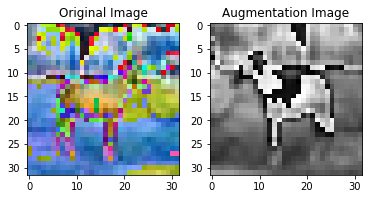

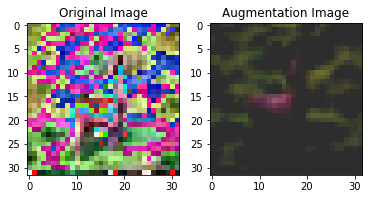

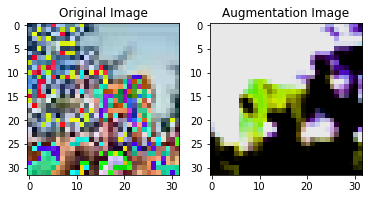

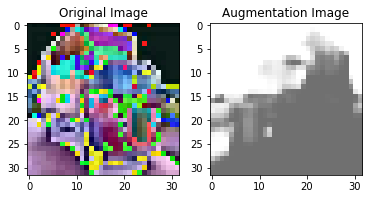

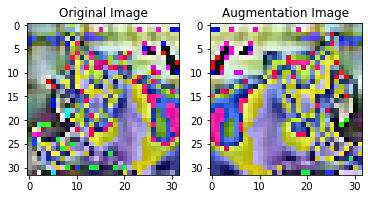

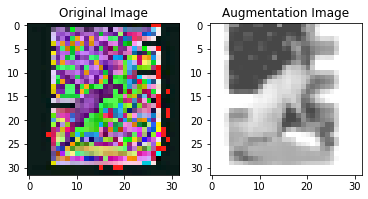

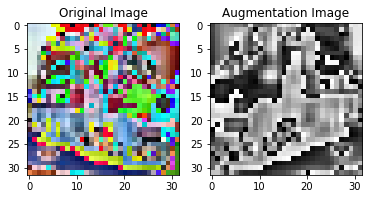

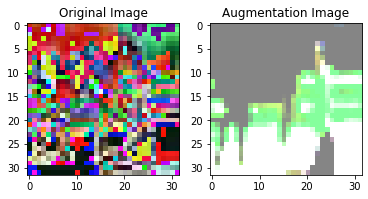

In [9]:
import matplotlib.pyplot as plt

def plot_images(im1, im2):
    plt.subplot(121)
    plt.title("Original Image")
    plt.imshow(im1)
    plt.subplot(122)
    plt.title("Augmentation Image")
    plt.imshow(im2)
    plt.show()
    
    
    
local_progress = tqdm(train_loader, desc=f'Epoch {1}/{1}')
for idx, (images, label) in enumerate(local_progress):
        images = images.to(device)
        aug_image = train_transform(images)
        break


for i in range(0,8):
    im = np.asarray(transforms.ToPILImage()(images[i,:,:,:])).copy()
    aug = np.asarray(transforms.ToPILImage()(aug_image[i,:,:,:]))
    
    plot_images(im,aug)
    


<ipython-input-10-6d13810c8d0c>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  global_progress = tqdm(range(0, epochs), desc=f'Training')


Training:   0%|          | 0/1 [00:00<?, ?it/s]

<ipython-input-10-6d13810c8d0c>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  local_progress = tqdm(train_loader, desc=f'Epoch {epoch}/{epochs}')


Epoch 0/1:   0%|          | 0/196 [00:00<?, ?it/s]

/home/octo/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:448: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


KeyboardInterrupt: 

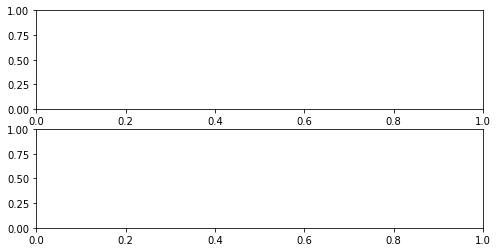

In [10]:
model = ContrastiveLearner().to(device)
optimizer = optim.Adam(model.parameters(), 
            lr=lr,
            weight_decay=False) 
scheduler = ExponentialLR(optimizer, gamma= 1)

min_loss = np.inf #ironic
accuracy = 0

# start training 
global_progress = tqdm(range(0, epochs), desc=f'Training')
data_dict = {"loss": 100}
for epoch in global_progress:
    model.train()   

    local_progress = tqdm(train_loader, desc=f'Epoch {epoch}/{epochs}')
    for idx, (image, label) in enumerate(local_progress):
        
        image = image.to(device)
        aug_image = train_transform(image)

        model.zero_grad()
        loss = model.forward(image.to(device, non_blocking=True),aug_image.to(device, non_blocking=True))

        data_dict['loss'] = loss.item() 
        loss.backward()
        optimizer.step()
        scheduler.step()
        data_dict.update({'lr': scheduler.get_lr()[0]})
        local_progress.set_postfix(data_dict)
        logger.update_scalers(data_dict)
        
    accuracy = knn_monitor(model.backbone, memory_loader, test_loader, device, hide_progress=True) 
    epoch_dict = {'epoch':epoch, 'accuracy':accuracy}
    global_progress.set_postfix(epoch_dict)
    logger.update_scalers(epoch_dict)

model_path = os.path.join(ckpt_dir, f"{uid}_{datetime.now().strftime('%m%d%H%M%S')}.pth")
torch.save({
    'epoch':epoch+1,
    'state_dict': model.module.state_dict()
        }, model_path)
print(f'Model saved at: {model_path}')